## Capstone Project: Using Facial Recognition to Identify Celebrities

This notebook contains my capstone project in the Professional Certificate in Machine Learning and Artificial Intelligence cource from the University of California, Berkeley.  The goal of the project is to properly identify a person from their image using ML techniques.

### Motivation

Facial recognition is important for several reasons.  These include enhancing security, streamlining access controls, and relieving or enhancing the capabilities of physical identification for security personnel. 

In [ ]:
##Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import os
from PIL import Image, ImageOps
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import TensorFlow components
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import tensorflow as tf

from tensorflow.keras.applications import ResNet50V2



from collections import defaultdict
import pickle
import face_recognition

from sklearn.neighbors import KNeighborsClassifier


/mnt/c/Users/stepa/projects/Capstone/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-28 21:37:47.647486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 21:37:48.416954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753763868.622192  709862 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753763868.680018  709862 cuda_b

### Data Set
The data set below has 17 celebrities with 100 pictures of each.  We will try to properly identify the clebrity based on their images  

In [ ]:
# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

#print("Path to dataset files:", path)

Path to dataset files: /home/jack/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


Total images: 1800
Mean pixels: 231,733
Median pixels: 231,549
Target pixels (224×224): 50,176
Min pixels: 21,600
Max pixels: 280,608


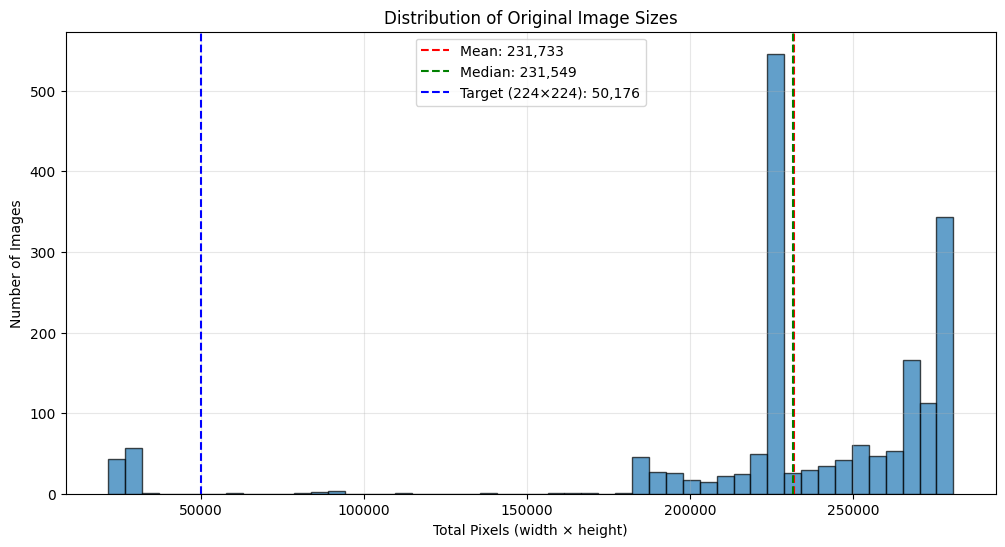

In [3]:
# Collect original image sizes for histogram
base_dir = os.path.expanduser(path + '//Celebrity Faces Dataset')
original_sizes = []

# Traverse each subfolder (person) to get original sizes
for person in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person)
    if os.path.isdir(person_dir):
        for filename in os.listdir(person_dir):
            if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
                img_path = os.path.join(person_dir, filename)
                try:
                    img = Image.open(img_path)
                    # Calculate total pixels (width * height)
                    total_pixels = img.size[0] * img.size[1]
                    original_sizes.append(total_pixels)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(original_sizes, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Total Pixels (width × height)')
plt.ylabel('Number of Images')
plt.title('Distribution of Original Image Sizes')
plt.grid(True, alpha=0.3)

# Add some statistics
mean_pixels = np.mean(original_sizes)
median_pixels = np.median(original_sizes)
target_pixels = 224 * 224  # Our target size

plt.axvline(mean_pixels, color='red', linestyle='--', label=f'Mean: {mean_pixels:,.0f}')
plt.axvline(median_pixels, color='green', linestyle='--', label=f'Median: {median_pixels:,.0f}')
plt.axvline(target_pixels, color='blue', linestyle='--', label=f'Target (224×224): {target_pixels:,}')

plt.legend()

print(f"Total images: {len(original_sizes)}")
print(f"Mean pixels: {mean_pixels:,.0f}")
print(f"Median pixels: {median_pixels:,.0f}")
print(f"Target pixels (224×224): {target_pixels:,}")
print(f"Min pixels: {min(original_sizes):,}")
print(f"Max pixels: {max(original_sizes):,}")

plt.show()

### Reading in the Images to be classifed
- Using the Python Image Library (PIL) we can achieve the following:
   - Convert all images to the same size with each having 3 channels of data
   - Greyscale images have their channels duplicated
   - Aspect ratios are corrected through cropping
   - Image size is correct through blurring or upsampling
- After reading in the images equalize the data set by dropping any oversampled celebrities

In [ ]:
# Path to the dataset
base_dir = os.path.expanduser(path + '//Celebrity Faces Dataset')
image_size = (224, 224)  # You can change this if you want a different size
print(base_dir)
images = []
labels = []
small_images = []  # List to track images smaller than 224x224

# Traverse each subfolder (person)
for person in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person)
    if os.path.isdir(person_dir):
        for filename in os.listdir(person_dir):
            if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
                img_path = os.path.join(person_dir, filename)
                try:
                    img = Image.open(img_path).convert('RGB')                  

                    # Check if image is smaller than 224x224
                    original_pixels = img.size[0] * img.size[1]
                    target_pixels = 224 * 224
                    
                    if original_pixels < target_pixels:
                        small_images.append({
                            'person': person,
                            'filename': filename,
                            'original_size': img.size,
                            'original_pixels': original_pixels
                        })
                    
                    img = ImageOps.pad(img, image_size, color=(0, 0, 0))
                    #img = img.convert('L')
                    images.append(np.array(img))
                    labels.append(person)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

images_np = np.array(images)
labels_np = np.array(labels)

#print(images_np.shape)  # (num_images, 224, 224, 3)
#print(labels_np.shape)  # (num_images,)
print(f"Number of images smaller than 224x224: {len(small_images)}")


/home/jack/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1//Celebrity Faces Dataset
(1800, 224, 224, 3)
(1800,)
Number of images smaller than 224x224: 101


In [5]:
# Step 1: Find the minimum number of images per celebrity
# Set the random seed for reproducible results
random.seed(42)  

images_per_celebrity = {}
for img, label in zip(images, labels):
    if label not in images_per_celebrity:
        images_per_celebrity[label] = []
    images_per_celebrity[label].append(img)

min_images = min(len(imgs) for imgs in images_per_celebrity.values())
print("Minimum images per celebrity:", min_images)

# Step 2: For each celebrity, randomly sample min_images images
balanced_images_per_celebrity = {}
for celeb, imgs in images_per_celebrity.items():
    if len(imgs) > min_images:
        balanced_images_per_celebrity[celeb] = random.sample(imgs, min_images)
    else:
        balanced_images_per_celebrity[celeb] = imgs

# Step 3: Create balanced images and labels lists
balanced_images = []
balanced_labels = []
for celeb, imgs in balanced_images_per_celebrity.items():
    balanced_images.extend(imgs)
    balanced_labels.extend([celeb] * len(imgs))

print("Original dataset size:", len(images))
print("Balanced dataset size:", len(balanced_images))
print("Images per celebrity:", min_images)

Minimum images per celebrity: 100
Original dataset size: 1800
Balanced dataset size: 1700
Images per celebrity: 100


#### Plot all the images to ensure they are as expected and we don't have any blanks or weird outliers

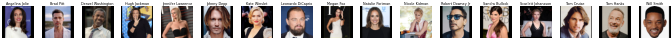

In [ ]:
# Get all unique celebrities from the balanced dataset
unique_celebrities = sorted(set(balanced_labels))
num_cols = len(unique_celebrities)

# Collect all images for each celebrity from the balanced dataset
images_per_celebrity = {celeb: [] for celeb in unique_celebrities}
for img, label in zip(balanced_images, balanced_labels):  # Use balanced_images and balanced_labels
    images_per_celebrity[label].append(img)

# Find the maximum number of images any celebrity has 
max_images = max(len(imgs) for imgs in images_per_celebrity.values())
max_images = 1
# Plot grid: rows = max_images, columns = num_cols (one per celebrity)
plt.figure(figsize=(2*num_cols, 2*max_images),  dpi=20)
for col, celeb in enumerate(unique_celebrities):
    for row in range(max_images):
        idx = row * num_cols + col + 1
        plt.subplot(max_images, num_cols, idx)
        if row < len(images_per_celebrity[celeb]):
            plt.imshow(images_per_celebrity[celeb][row])
        plt.axis('off')
        if row == 0:
            plt.title(celeb, fontsize=12)
plt.tight_layout()
plt.show()



#### Data Reduction Summary and Next Steps
- Pruning the data set into something usable was fairly straightforward the numpy libraries do a good job of sizing and handling images for training
- We will try Four techniques to classify the images:
    - Importing Google's facenet library
    - Using our own crafted Convolutional Neural Network (CNN)
    - Using a transfer learing Neural Network 
    - Using a K Nearest Neighbors (KNN) approach to identify the celebrities 


In [ ]:
### Split the training and test data



=== FACE RECOGNITION - TRAIN/TEST SPLIT ===
1. Extracting face encodings...
Extracting face encodings...
Processing image 0/1700
No face detected in image 9
No face detected in image 54
Processing image 100/1700
No face detected in image 134
No face detected in image 172
No face detected in image 196
Processing image 200/1700
Processing image 300/1700
Processing image 400/1700
No face detected in image 456
Processing image 500/1700
Processing image 600/1700
No face detected in image 610
No face detected in image 679
Processing image 700/1700
No face detected in image 790
No face detected in image 793
Processing image 800/1700
No face detected in image 862
Processing image 900/1700
No face detected in image 911
No face detected in image 953
No face detected in image 974
Processing image 1000/1700
No face detected in image 1035
No face detected in image 1095
Processing image 1100/1700
No face detected in image 1152
No face detected in image 1171
Processing image 1200/1700
Processing imag

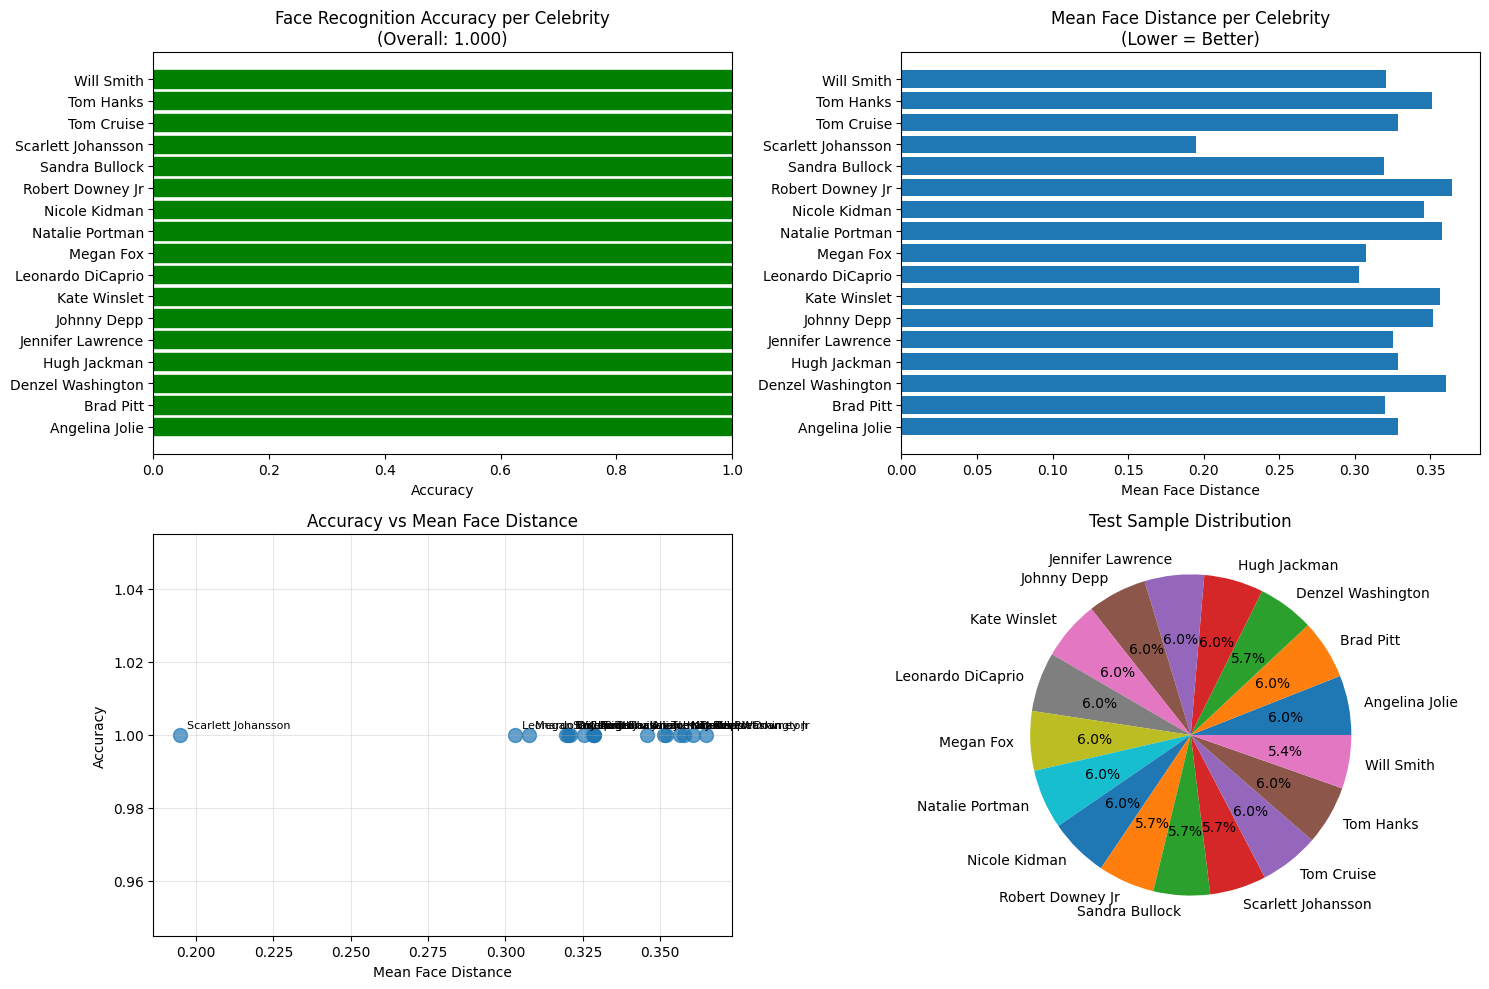


DETAILED RESULTS PER CELEBRITY
 1. Angelina Jolie      : 1.000 (distance: 0.328±0.082) [20/20 samples]
 2. Brad Pitt           : 1.000 (distance: 0.320±0.078) [20/20 samples]
 3. Denzel Washington   : 1.000 (distance: 0.361±0.069) [19/19 samples]
 4. Hugh Jackman        : 1.000 (distance: 0.328±0.070) [20/20 samples]
 5. Jennifer Lawrence   : 1.000 (distance: 0.325±0.062) [20/20 samples]
 6. Johnny Depp         : 1.000 (distance: 0.352±0.068) [20/20 samples]
 7. Kate Winslet        : 1.000 (distance: 0.357±0.090) [20/20 samples]
 8. Leonardo DiCaprio   : 1.000 (distance: 0.303±0.072) [20/20 samples]
 9. Megan Fox           : 1.000 (distance: 0.307±0.082) [20/20 samples]
10. Natalie Portman     : 1.000 (distance: 0.358±0.056) [20/20 samples]
11. Nicole Kidman       : 1.000 (distance: 0.346±0.067) [20/20 samples]
12. Robert Downey Jr    : 1.000 (distance: 0.365±0.070) [19/19 samples]
13. Sandra Bullock      : 1.000 (distance: 0.320±0.056) [19/19 samples]
14. Scarlett Johansson  : 1.000 

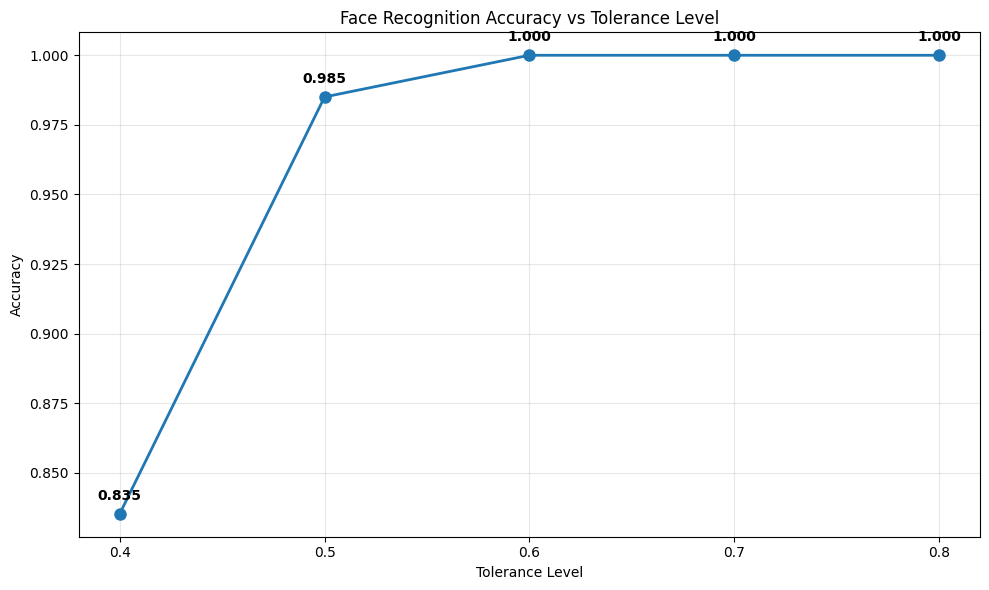


Best tolerance: 0.6
Best accuracy: 1.000


In [ ]:


def face_recognition_train_test(face_encodings, labels, test_size=0.2, tolerance=0.6):
    """Face recognition using train/test split instead of cross-validation"""
    print(f"\n{'='*50}")
    print("FACE RECOGNITION - TRAIN/TEST SPLIT")
    print(f"{'='*50}")
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)
    celebrity_names = le.classes_
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        face_encodings, y_encoded, 
        test_size=test_size, 
        random_state=42, 
        stratify=y_encoded
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Number of celebrities: {len(celebrity_names)}")
    
    # Test face recognition
    correct_predictions = 0
    total_predictions = len(X_test)
    predictions = []
    true_labels = []
    
    print(f"\nTesting with tolerance: {tolerance}")
    
    for i, test_encoding in enumerate(X_test):
        if i % 50 == 0:
            print(f"Processing test image {i}/{len(X_test)}")
        
        # Get face distances to all training faces
        face_distances = face_recognition.face_distance(X_train, test_encoding)
        
        # Find the closest match
        best_match_index = np.argmin(face_distances)
        best_distance = face_distances[best_match_index]
        
        # Get true and predicted labels
        true_label = y_test[i]
        predicted_label = y_train[best_match_index]
        
        # Check if prediction is correct (within tolerance)
        if best_distance <= tolerance:
            if predicted_label == true_label:
                correct_predictions += 1
            predictions.append(predicted_label)
        else:
            # No match found within tolerance - could assign random or most common class
            predictions.append(predicted_label)  # Still use closest match
        
        true_labels.append(true_label)
    
    # Calculate overall accuracy
    overall_accuracy = correct_predictions / total_predictions
    
    print(f"\nOverall Results:")
    print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    
    return overall_accuracy, predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test

def analyze_celebrity_performance_train_test(predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test, tolerance=0.6):
    """Analyze performance per celebrity using train/test split"""
    print(f"\n{'='*50}")
    print("CELEBRITY PERFORMANCE ANALYSIS (TRAIN/TEST)")
    print(f"{'='*50}")
    
    # Dictionary to store results for each celebrity
    celebrity_results = {name: {'correct': 0, 'total': 0, 'distances': []} for name in celebrity_names}
    
    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        celeb_name = celebrity_names[true]
        
        # Get the actual distance for this prediction
        test_encoding = X_test[i]
        face_distances = face_recognition.face_distance(X_train, test_encoding)
        best_distance = np.min(face_distances)
        
        celebrity_results[celeb_name]['total'] += 1
        celebrity_results[celeb_name]['distances'].append(best_distance)
        
        if pred == true:
            celebrity_results[celeb_name]['correct'] += 1
    
    # Calculate statistics per celebrity
    celebrity_accuracies = {}
    for celeb in celebrity_names:
        if celebrity_results[celeb]['total'] > 0:
            accuracy = celebrity_results[celeb]['correct'] / celebrity_results[celeb]['total']
            mean_distance = np.mean(celebrity_results[celeb]['distances'])
            std_distance = np.std(celebrity_results[celeb]['distances'])
            
            celebrity_accuracies[celeb] = {
                'accuracy': accuracy,
                'mean_distance': mean_distance,
                'std_distance': std_distance,
                'total_samples': celebrity_results[celeb]['total'],
                'correct_predictions': celebrity_results[celeb]['correct']
            }
    
    return celebrity_accuracies

def visualize_train_test_results(celebrity_accuracies, overall_accuracy):
    """Visualize train/test results"""
    celebrities = list(celebrity_accuracies.keys())
    accuracies = [celebrity_accuracies[celeb]['accuracy'] for celeb in celebrities]
    mean_distances = [celebrity_accuracies[celeb]['mean_distance'] for celeb in celebrities]
    sample_counts = [celebrity_accuracies[celeb]['total_samples'] for celeb in celebrities]
    
    # Sort by accuracy
    sorted_indices = np.argsort(accuracies)
    celebrities_sorted = [celebrities[i] for i in sorted_indices]
    accuracies_sorted = [accuracies[i] for i in sorted_indices]
    mean_distances_sorted = [mean_distances[i] for i in sorted_indices]
    sample_counts_sorted = [sample_counts[i] for i in sorted_indices]
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Accuracy per celebrity
    plt.subplot(2, 2, 1)
    bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
    plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
    plt.xlabel('Accuracy')
    plt.title(f'Face Recognition Accuracy per Celebrity\n(Overall: {overall_accuracy:.3f})')
    plt.xlim(0, 1)
    
    # Color bars based on performance
    for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
        if acc >= 0.8:
            bar.set_color('green')
        elif acc >= 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    # Plot 2: Mean face distance per celebrity
    plt.subplot(2, 2, 2)
    plt.barh(range(len(celebrities_sorted)), mean_distances_sorted)
    plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
    plt.xlabel('Mean Face Distance')
    plt.title('Mean Face Distance per Celebrity\n(Lower = Better)')
    
    # Plot 3: Accuracy vs Mean Distance
    plt.subplot(2, 2, 3)
    plt.scatter(mean_distances_sorted, accuracies_sorted, s=100, alpha=0.7)
    for i, celeb in enumerate(celebrities_sorted):
        plt.annotate(celeb, (mean_distances_sorted[i], accuracies_sorted[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    plt.xlabel('Mean Face Distance')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Mean Face Distance')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Sample distribution
    plt.subplot(2, 2, 4)
    plt.pie(sample_counts_sorted, labels=celebrities_sorted, autopct='%1.1f%%')
    plt.title('Test Sample Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*50}")
    print("DETAILED RESULTS PER CELEBRITY")
    print(f"{'='*50}")
    
    # Sort by accuracy (best first)
    sorted_by_acc = sorted(celebrity_accuracies.items(), 
                          key=lambda x: x[1]['accuracy'], reverse=True)
    
    for i, (celeb, results) in enumerate(sorted_by_acc):
        print(f"{i+1:2d}. {celeb:20s}: {results['accuracy']:.3f} "
              f"(distance: {results['mean_distance']:.3f}±{results['std_distance']:.3f}) "
              f"[{results['correct_predictions']}/{results['total_samples']} samples]")
    
    # Summary statistics
    all_accuracies = [results['accuracy'] for results in celebrity_accuracies.values()]
    all_distances = [results['mean_distance'] for results in celebrity_accuracies.values()]
    
    print(f"\nSummary:")
    print(f"  Overall accuracy: {overall_accuracy:.3f}")
    print(f"  Mean accuracy across celebrities: {np.mean(all_accuracies):.3f}")
    print(f"  Std accuracy across celebrities: {np.std(all_accuracies):.3f}")
    print(f"  Mean face distance: {np.mean(all_distances):.3f}")
    print(f"  Best celebrity: {sorted_by_acc[0][0]} ({sorted_by_acc[0][1]['accuracy']:.3f})")
    print(f"  Worst celebrity: {sorted_by_acc[-1][0]} ({sorted_by_acc[-1][1]['accuracy']:.3f})")

# Main execution with train/test split
print("=== FACE RECOGNITION - TRAIN/TEST SPLIT ===")

# Use your balanced dataset
print("1. Extracting face encodings...")
face_encodings, valid_labels, failed_images = extract_face_encodings(
    balanced_images, balanced_labels
)

print(f"\n2. Running train/test split...")
overall_accuracy, predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test = face_recognition_train_test(
    face_encodings, valid_labels, test_size=0.2, tolerance=0.6
)

print(f"\n3. Analyzing celebrity performance...")
celebrity_accuracies = analyze_celebrity_performance_train_test(
    predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test, tolerance=0.6
)

print(f"\n4. Visualizing results...")
visualize_train_test_results(celebrity_accuracies, overall_accuracy)

# Test different tolerance levels
print(f"\n5. Testing different tolerance levels...")
tolerance_levels = [0.4, 0.5, 0.6, 0.7, 0.8]
tolerance_results = {}

for tolerance in tolerance_levels:
    print(f"\nTesting tolerance: {tolerance}")
    acc, _, _, _, _, _, _, _ = face_recognition_train_test(
        face_encodings, valid_labels, test_size=0.2, tolerance=tolerance
    )
    tolerance_results[tolerance] = acc

# Plot tolerance results
plt.figure(figsize=(10, 6))
tolerances = list(tolerance_results.keys())
accuracies = list(tolerance_results.values())

plt.plot(tolerances, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Tolerance Level')
plt.ylabel('Accuracy')
plt.title('Face Recognition Accuracy vs Tolerance Level')
plt.grid(True, alpha=0.3)
plt.xticks(tolerances)

# Add value labels on points
for i, (tol, acc) in enumerate(zip(tolerances, accuracies)):
    plt.annotate(f'{acc:.3f}', (tol, acc), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nBest tolerance: {max(tolerance_results, key=tolerance_results.get)}")
print(f"Best accuracy: {max(tolerance_results.values()):.3f}")

This serves as a good baseline for what we can hope to achieve

=== Face Detection with face_recognition ===
Detecting and cropping faces...
Successfully cropped 1669 faces
Failed to process 31 images


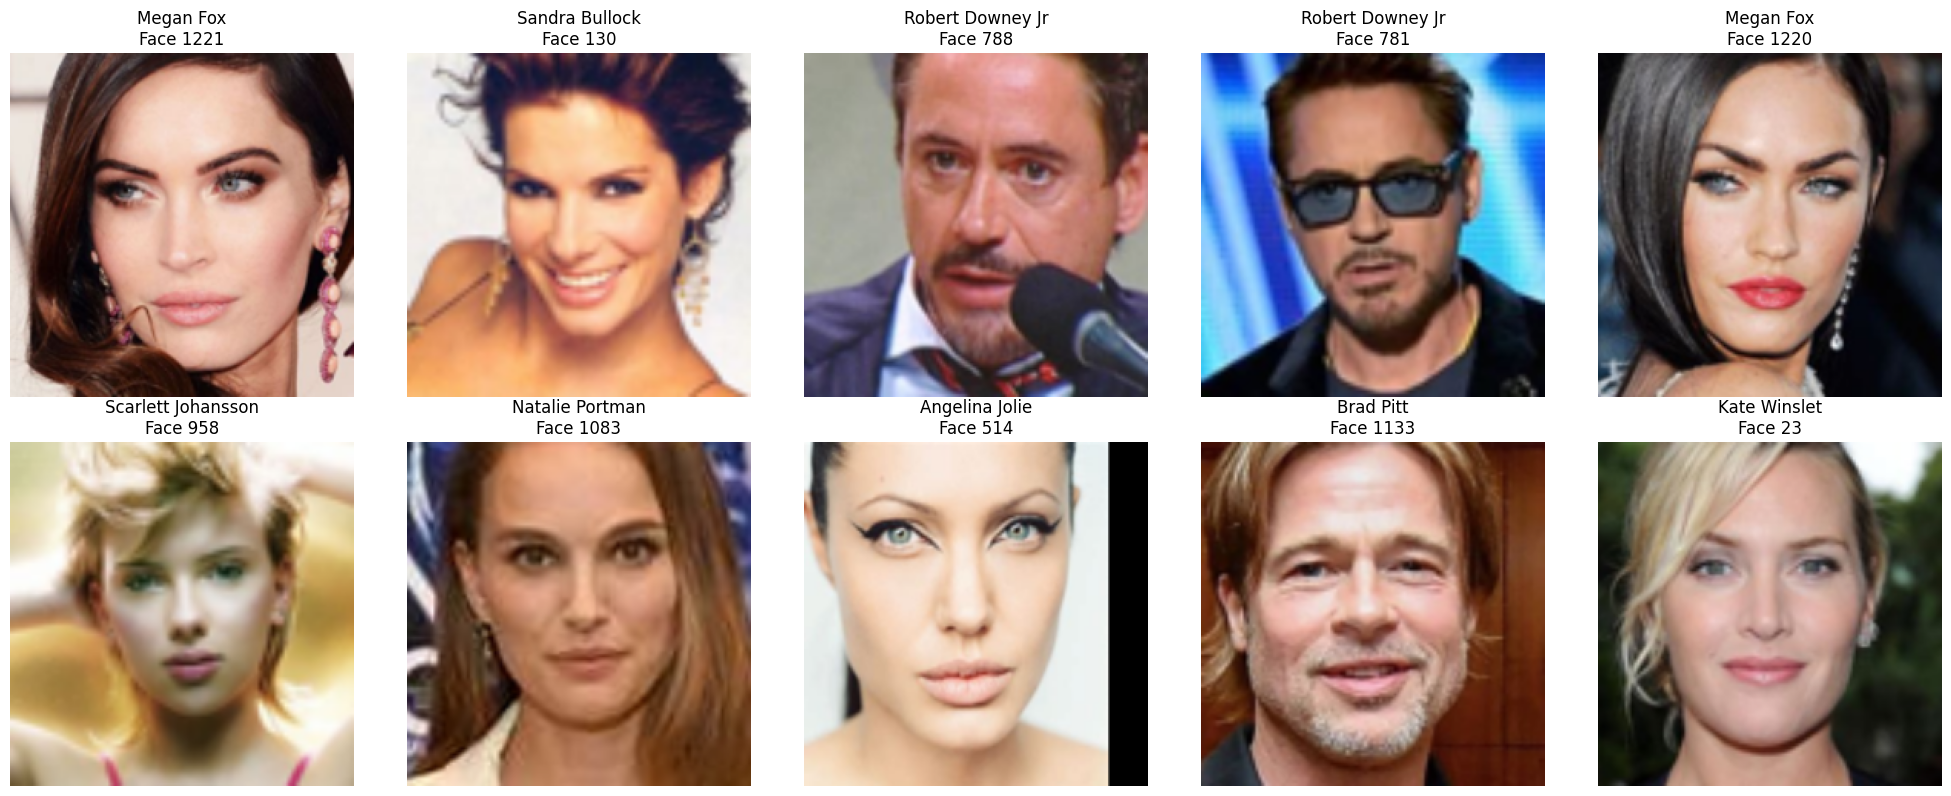

In [60]:
def detect_and_crop_faces(images, labels):
    """Just detect and crop faces without encoding"""
    print("Detecting and cropping faces...")
    
    cropped_faces = []
    valid_labels = []
    failed_images = []
    face_locations = []
    
    for i, (img, label) in enumerate(zip(images, labels)):
        #if i % 100 == 0:
        #    print(f"Processing image {i}/{len(images)}")
        
        try:
            # Convert to RGB if needed
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            
            # Detect face locations
            locations = face_recognition.face_locations(img)
            
            if len(locations) > 0:
                # Use the first face found
                top, right, bottom, left = locations[0]
                
                # Crop the face with some margin
                margin = 20
                top = max(0, top - margin)
                left = max(0, left - margin)
                bottom = min(img.shape[0], bottom + margin)
                right = min(img.shape[1], right + margin)
                
                # Crop the face
                face_crop = img[top:bottom, left:right]
                
                # Resize to standard size
                face_crop = cv2.resize(face_crop, (224, 224))
                
                cropped_faces.append(face_crop)
                valid_labels.append(label)
                face_locations.append(locations[0])
            else:
                failed_images.append(i)
                #print(f"No face detected in image {i}")
                
        except Exception as e:
            failed_images.append(i)
            #print(f"Error processing image {i}: {e}")
    
    print(f"Successfully cropped {len(cropped_faces)} faces")
    print(f"Failed to process {len(failed_images)} images")
    
    return np.array(cropped_faces), np.array(valid_labels), failed_images, face_locations



# Use face_recognition for detection and cropping
print("=== Face Detection with face_recognition ===")
cropped_faces, valid_labels, failed_images, face_locations = detect_and_crop_faces(
    balanced_images, balanced_labels
)


# Visualize some cropped faces
def visualize_cropped_faces(cropped_faces, labels, num_samples=10):
    """Visualize some cropped faces"""
    import random
    
    # Randomly sample faces
    indices = random.sample(range(len(cropped_faces)), min(num_samples, len(cropped_faces)))
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i < len(axes):
            axes[i].imshow(cropped_faces[idx])
            axes[i].set_title(f'{labels[idx]}\nFace {idx}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize the cropped faces
visualize_cropped_faces(cropped_faces, valid_labels, num_samples=10)



Original shape: (1669, 224, 224, 3)
Resized shape: (1669, 128, 128, 3)
Number of celebrities: 17


/mnt/c/Users/stepa/projects/Capstone/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 6, 6, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 2, 2, 512)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,361 (10.50 MB)

 Trainable params: 2,753,361 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

Test accuracy: 0.5729


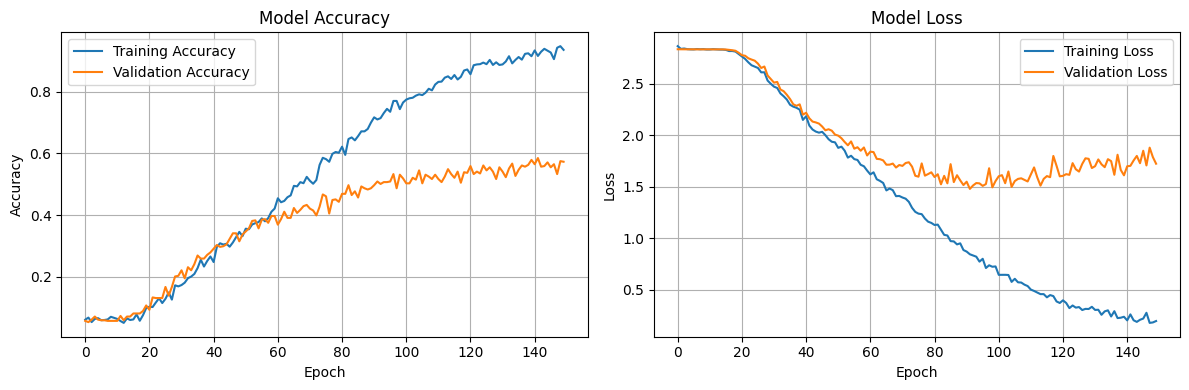

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


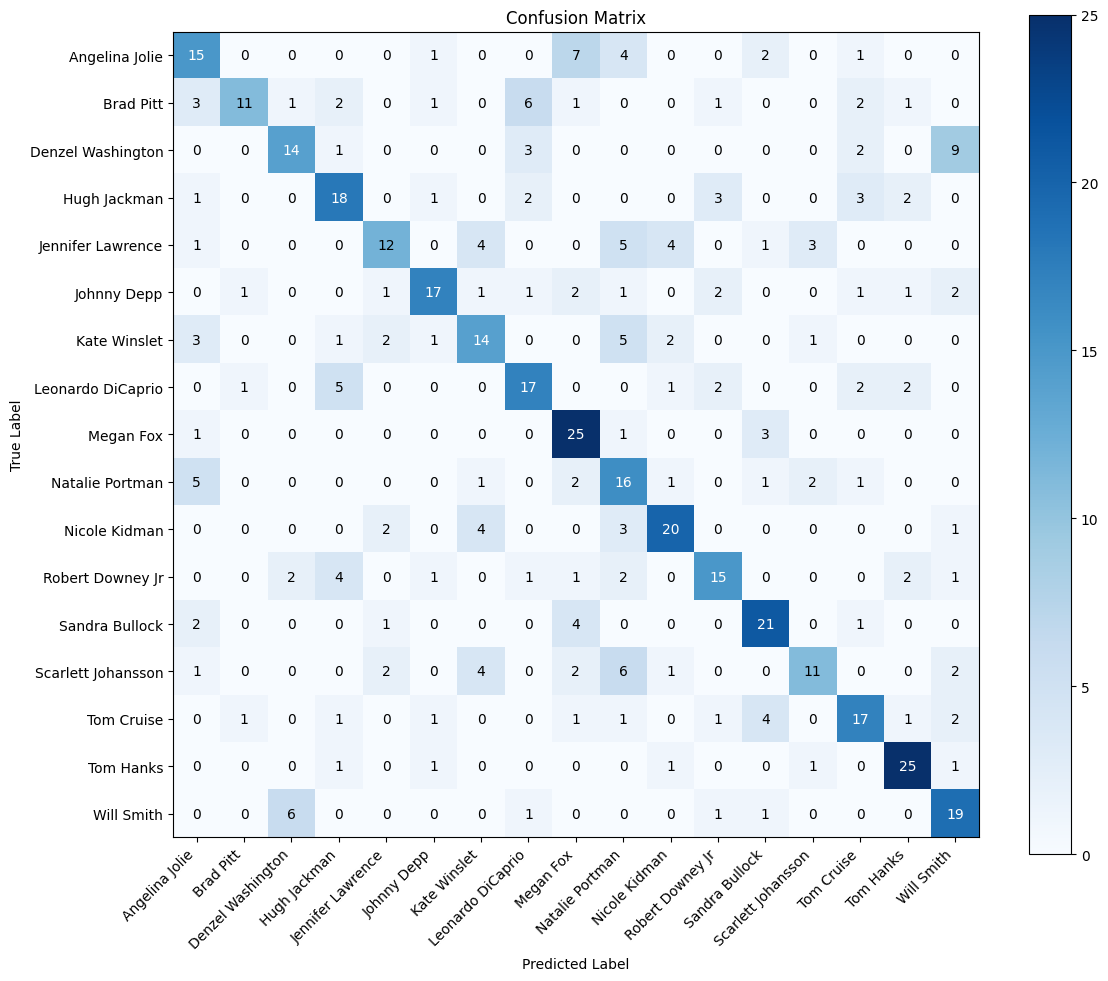

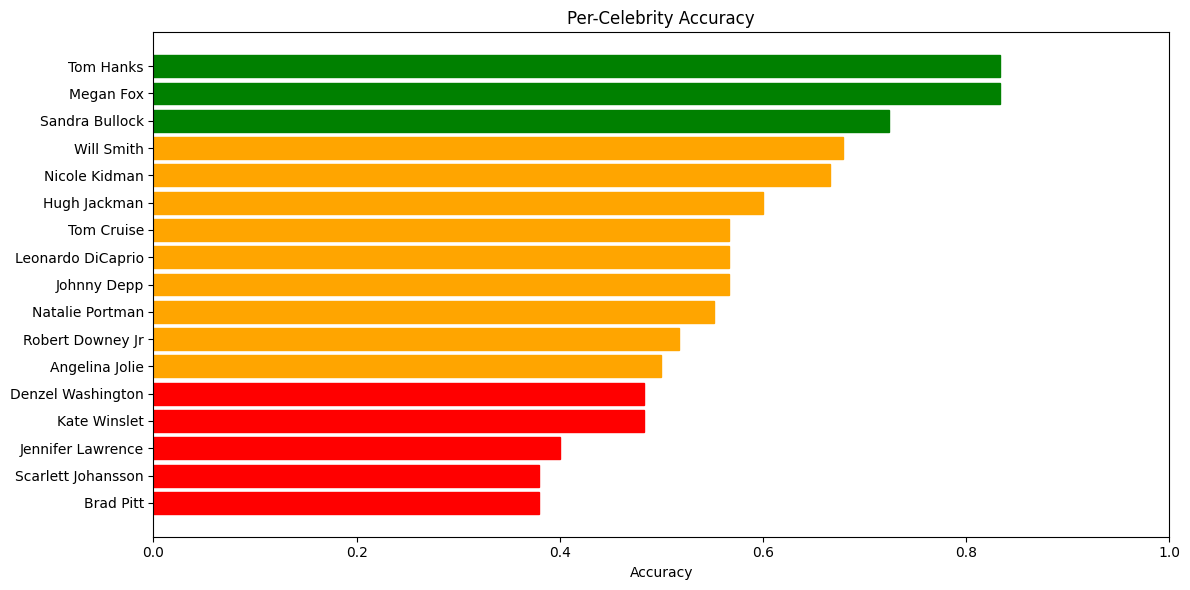

In [88]:
# Resize images to smaller dimensions
def resize_images(images, target_size=(32, 32)):
    """Resize all images to smaller dimensions"""
    resized_images = []
    for img in images:
        # Convert numpy array to PIL Image
        pil_img = Image.fromarray(img.astype('uint8'))
        # Resize
        resized_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)
        # Convert back to numpy array
        resized_images.append(np.array(resized_img))
    return np.array(resized_images)

# Resize your images to 64x64 (much smaller)
target_size = (128, 128)
resized_images = resize_images(cropped_faces, target_size)

print(f"Original shape: {np.array(cropped_faces).shape}")
print(f"Resized shape: {resized_images.shape}")

# Normalize
images_normalized = resized_images.astype('float32') / 255.0

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(valid_labels)

num_classes = len(le.classes_)
print(f"Number of celebrities: {num_classes}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Create model for smaller input
#model = Sequential([
#    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#    MaxPooling2D((2, 2)),
   
#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
   
#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
   

#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
   
#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
    
#    Flatten(),
#    Dense(128, activation='relu'),
#    Dropout(0.3),
#    Dense(num_classes, activation='softmax')
#])

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3), activation='relu'),  # Extra conv layer
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    #optimizer=Adam(learning_rate=0.0001),
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    verbose=0
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")


# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get predictions for detailed analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy
celeb_accuracies = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_classes[mask] == y_test[mask])
        celeb_accuracies[celeb] = celeb_accuracy
        #print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy as bar chart
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies.keys())
accuracies = list(celeb_accuracies.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title('Per-Celebrity Accuracy')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()



Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,749,585 (94.41 MB)

 Trainable params: 1,184,785 (4.52 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Test accuracy: 0.5549


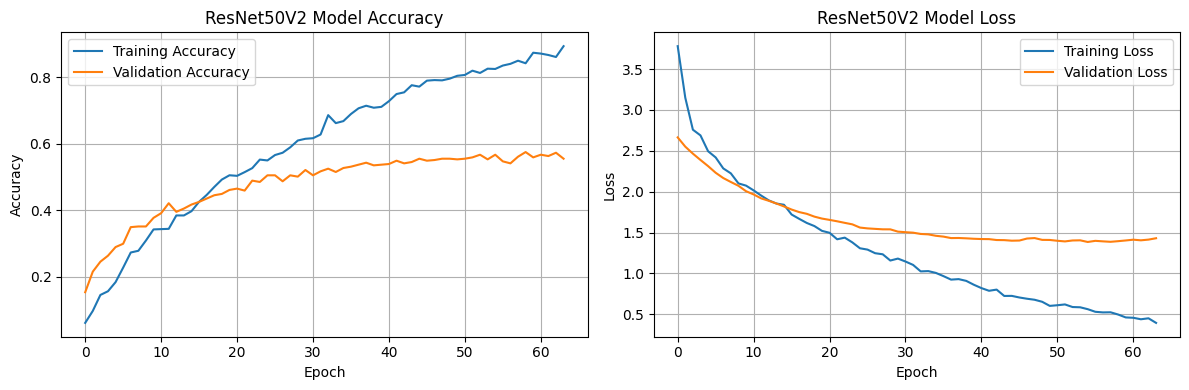

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step


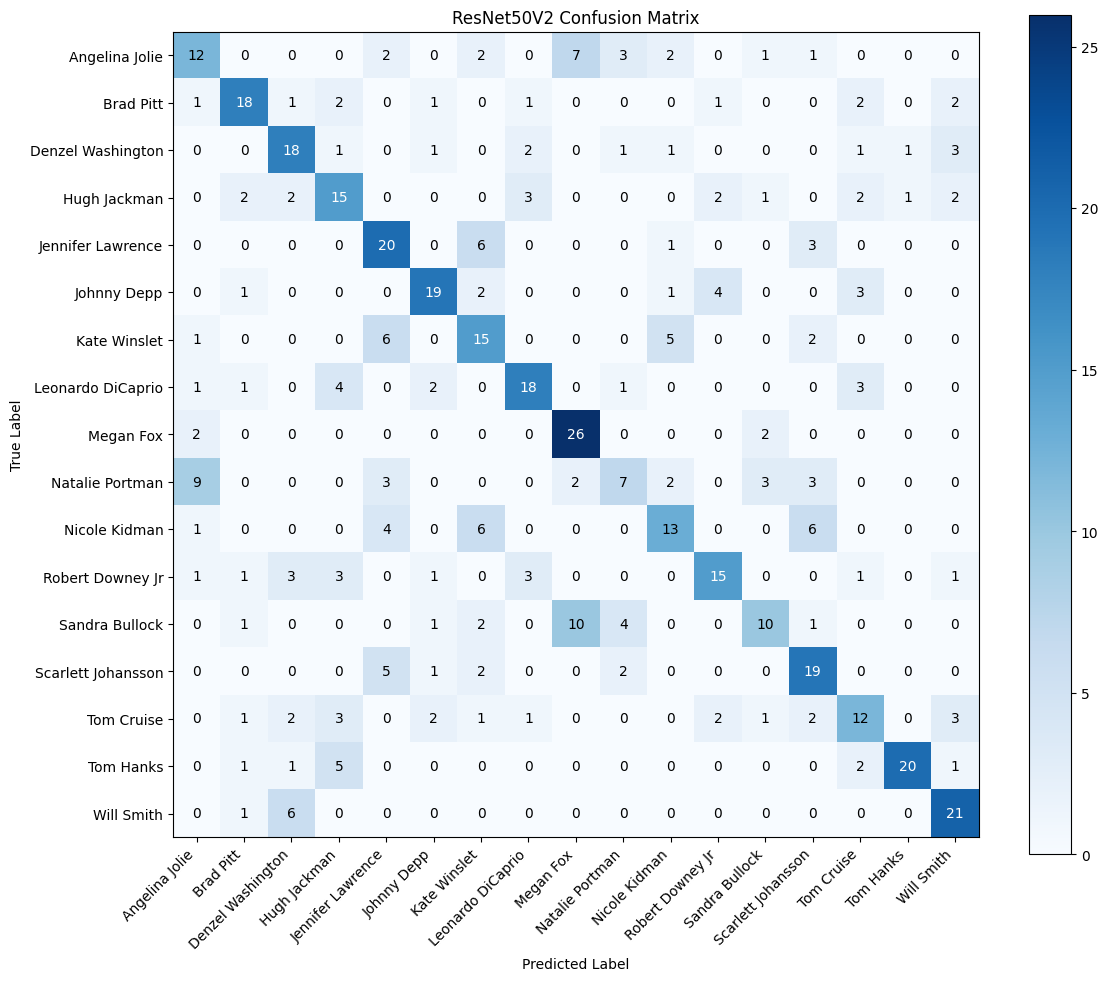


=== Per-Celebrity Accuracy (ResNet50V2) ===
Angelina Jolie      : 0.400 (30 samples)
Brad Pitt           : 0.621 (29 samples)
Denzel Washington   : 0.621 (29 samples)
Hugh Jackman        : 0.500 (30 samples)
Jennifer Lawrence   : 0.667 (30 samples)
Johnny Depp         : 0.633 (30 samples)
Kate Winslet        : 0.517 (29 samples)
Leonardo DiCaprio   : 0.600 (30 samples)
Megan Fox           : 0.867 (30 samples)
Natalie Portman     : 0.241 (29 samples)
Nicole Kidman       : 0.433 (30 samples)
Robert Downey Jr    : 0.517 (29 samples)
Sandra Bullock      : 0.345 (29 samples)
Scarlett Johansson  : 0.655 (29 samples)
Tom Cruise          : 0.400 (30 samples)
Tom Hanks           : 0.667 (30 samples)
Will Smith          : 0.750 (28 samples)


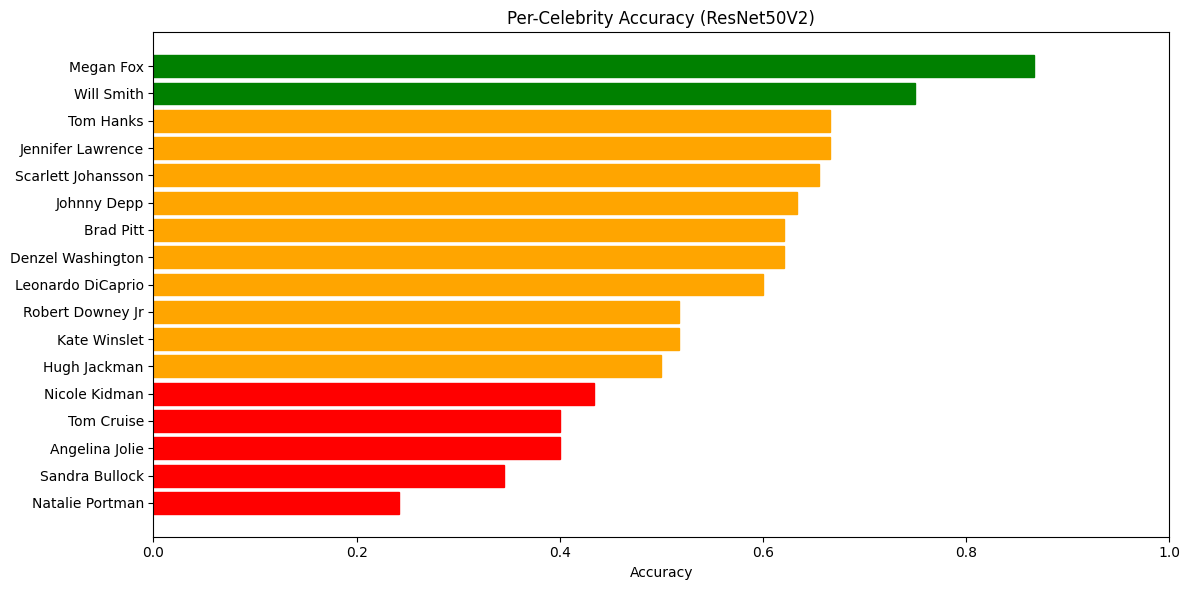

In [ ]:
# Use pre-trained ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=64,  
    batch_size=32,
    verbose=0
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")


#####PLOTS#####

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50V2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50V2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get predictions for detailed analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('ResNet50V2 Confusion Matrix')
plt.colorbar()

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy bar chart
#print("\n=== Per-Celebrity Accuracy (ResNet50V2) ===")
celeb_accuracies = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_classes[mask] == y_test[mask])
        celeb_accuracies[celeb] = celeb_accuracy
        #print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy as bar chart
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies.keys())
accuracies = list(celeb_accuracies.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title('Per-Celebrity Accuracy (ResNet50V2)')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()




Training KNN with 128 features per image

Training KNN with k=1
KNN (k=1) accuracy: 1.0000

Training KNN with k=3
KNN (k=3) accuracy: 1.0000

Training KNN with k=5
KNN (k=5) accuracy: 1.0000

Training KNN with k=7
KNN (k=7) accuracy: 1.0000

Training KNN with k=9
KNN (k=9) accuracy: 1.0000

Training KNN with k=11
KNN (k=11) accuracy: 1.0000

Best k: 1 with accuracy: 1.0000


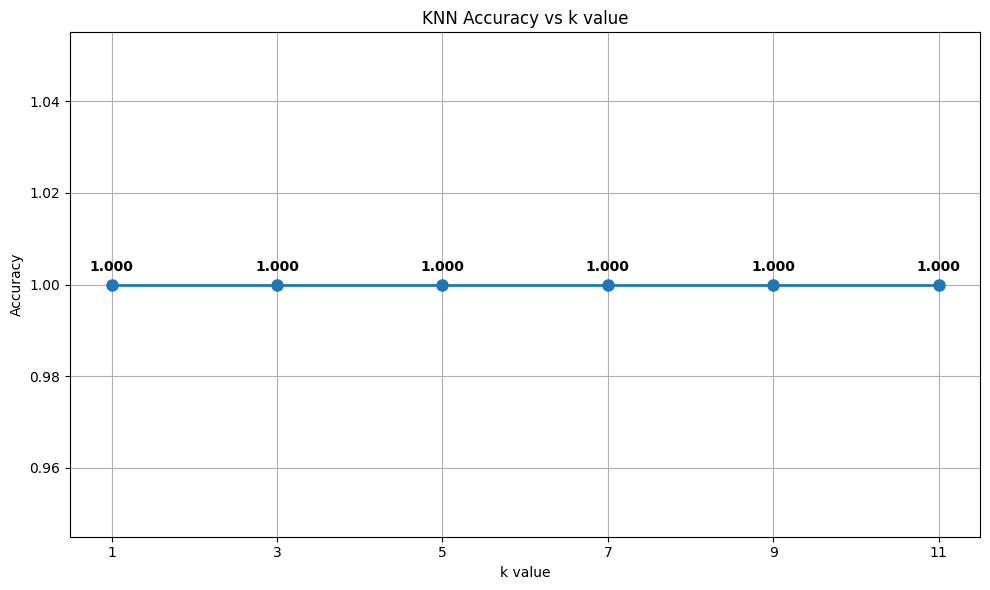


=== KNN Classification Report (k=1) ===
                    precision    recall  f1-score   support

    Angelina Jolie       1.00      1.00      1.00        20
         Brad Pitt       1.00      1.00      1.00        20
 Denzel Washington       1.00      1.00      1.00        19
      Hugh Jackman       1.00      1.00      1.00        20
 Jennifer Lawrence       1.00      1.00      1.00        20
       Johnny Depp       1.00      1.00      1.00        20
      Kate Winslet       1.00      1.00      1.00        20
 Leonardo DiCaprio       1.00      1.00      1.00        20
         Megan Fox       1.00      1.00      1.00        20
   Natalie Portman       1.00      1.00      1.00        20
     Nicole Kidman       1.00      1.00      1.00        20
  Robert Downey Jr       1.00      1.00      1.00        19
    Sandra Bullock       1.00      1.00      1.00        19
Scarlett Johansson       1.00      1.00      1.00        19
        Tom Cruise       1.00      1.00      1.00        2

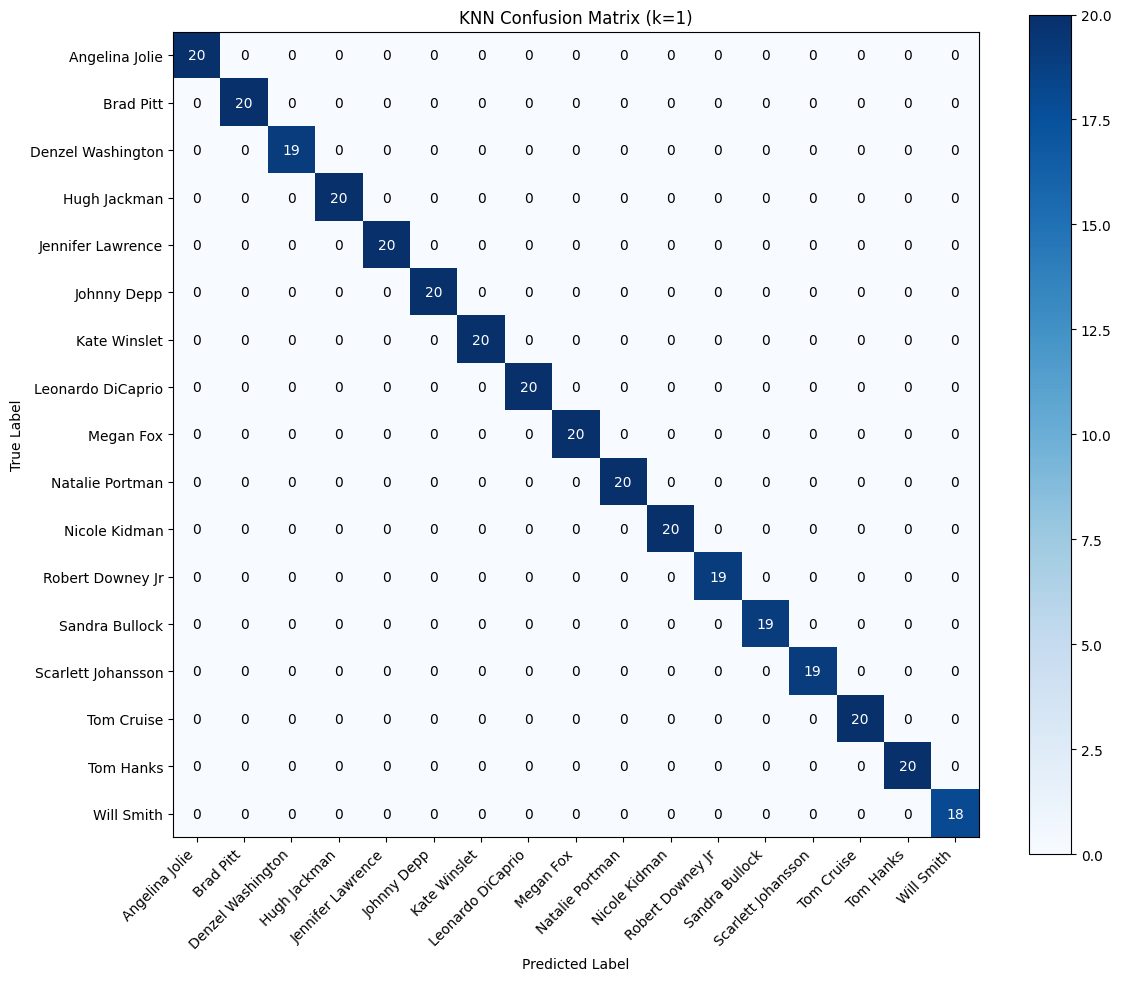


=== Per-Celebrity Accuracy (KNN k=1) ===
Angelina Jolie      : 1.000 (20 samples)
Brad Pitt           : 1.000 (20 samples)
Denzel Washington   : 1.000 (19 samples)
Hugh Jackman        : 1.000 (20 samples)
Jennifer Lawrence   : 1.000 (20 samples)
Johnny Depp         : 1.000 (20 samples)
Kate Winslet        : 1.000 (20 samples)
Leonardo DiCaprio   : 1.000 (20 samples)
Megan Fox           : 1.000 (20 samples)
Natalie Portman     : 1.000 (20 samples)
Nicole Kidman       : 1.000 (20 samples)
Robert Downey Jr    : 1.000 (19 samples)
Sandra Bullock      : 1.000 (19 samples)
Scarlett Johansson  : 1.000 (19 samples)
Tom Cruise          : 1.000 (20 samples)
Tom Hanks           : 1.000 (20 samples)
Will Smith          : 1.000 (18 samples)


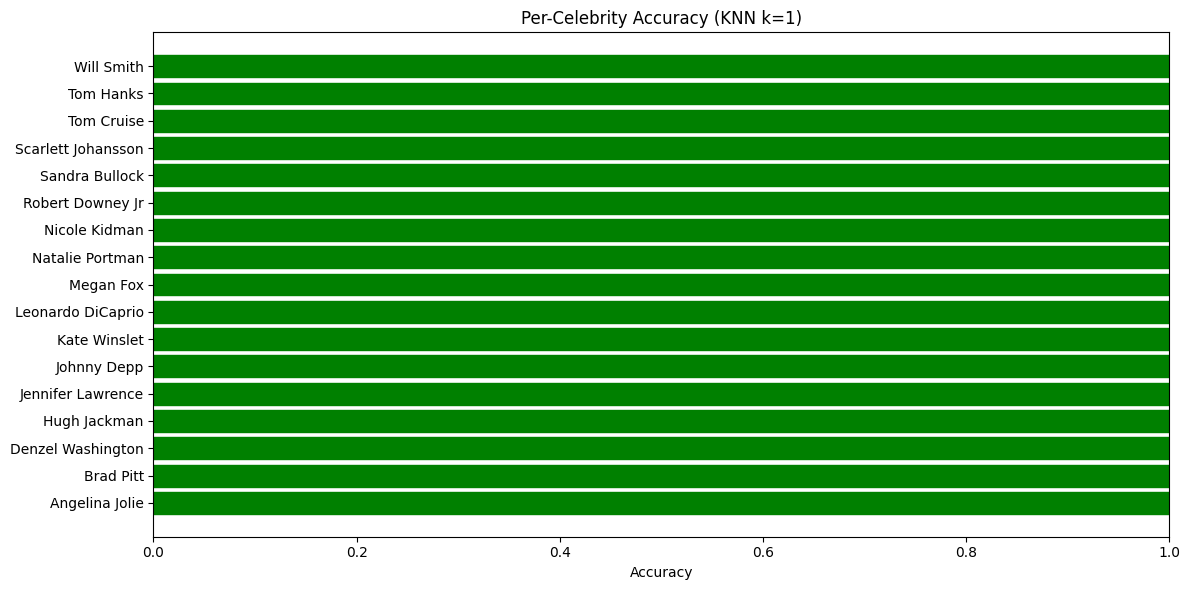


=== Model Comparison ===
KNN (k=1) accuracy: 1.0000


NameError: name 'test_accuracy' is not defined

In [ ]:

# Flatten the images for KNN (KNN expects 1D features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Training KNN with {X_train_flat.shape[1]} features per image")

# Try different k values
k_values = [1, 3, 5, 7, 9, 11]
knn_results = {}

for k in k_values:
    print(f"\nTraining KNN with k={k}")
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_flat, y_train)
    
    # Predict
    y_pred_knn = knn.predict(X_test_flat)
    accuracy = accuracy_score(y_test, y_pred_knn)
    knn_results[k] = accuracy
    
    print(f"KNN (k={k}) accuracy: {accuracy:.4f}")

# Find best k
best_k = max(knn_results, key=knn_results.get)
print(f"\nBest k: {best_k} with accuracy: {knn_results[best_k]:.4f}")

# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
best_knn.fit(X_train_flat, y_train)
y_pred_knn = best_knn.predict(X_test_flat)

# Plot KNN results
plt.figure(figsize=(10, 6))
k_list = list(knn_results.keys())
acc_list = list(knn_results.values())

plt.plot(k_list, acc_list, marker='o', linewidth=2, markersize=8)
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs k value')
plt.grid(True)
plt.xticks(k_list)

# Add value labels on points
for i, (k, acc) in enumerate(zip(k_list, acc_list)):
    plt.annotate(f'{acc:.3f}', (k, acc), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print classification report
print(f"\n=== KNN Classification Report (k={best_k}) ===")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Plot confusion matrix for KNN
plt.figure(figsize=(12, 10))
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'KNN Confusion Matrix (k={best_k})')
plt.colorbar()

# Add text annotations
thresh = cm_knn.max() / 2.
for i in range(cm_knn.shape[0]):
    for j in range(cm_knn.shape[1]):
        plt.text(j, i, format(cm_knn[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_knn[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy for KNN
print(f"\n=== Per-Celebrity Accuracy (KNN k={best_k}) ===")
celeb_accuracies_knn = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_knn[mask] == y_test[mask])
        celeb_accuracies_knn[celeb] = celeb_accuracy
        print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy bar chart for KNN
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies_knn.keys())
accuracies = list(celeb_accuracies_knn.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title(f'Per-Celebrity Accuracy (KNN k={best_k})')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

# Compare KNN vs ResNet
print(f"\n=== Model Comparison ===")
print(f"KNN (k={best_k}) accuracy: {knn_results[best_k]:.4f}")
print(f"ResNet50V2 accuracy: {test_accuracy:.4f}")